### get latent representations
- EDA plots of activations for train, test and perturbed data:
    - original hidden dimensions (512)
    - sparse activations / representation (32768)

- To understand general shape and pattern of these data distributions, how do they compare / differ qualitatively

- original activations: show similar distributions across train, test and test-perturbed datasets

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch as t

from utils.data_utils import load_target_concept_data, read_from_pt_gz, save_to_pt_gz
from sae_lens import SAE, HookedSAETransformer

In [2]:
## load pythia with hooked transformer for consistent comparison
device = "cpu"
pythia_model: HookedSAETransformer = HookedSAETransformer.from_pretrained('EleutherAI/pythia-70m-deduped', device=device)

Loaded pretrained model EleutherAI/pythia-70m-deduped into HookedTransformer


In [22]:
sae_release = "pythia-70m-deduped-res-sm"
sae_id = "blocks.4.hook_resid_post"
sae = SAE.from_pretrained(sae_release, sae_id)[0]

In [10]:
## load data 
import json
def read_from_json_file(filepath):
    with open(filepath, "r") as file:
        data = json.load(file)
    return data

## train data: harmful, non-harmful 
train_harmful = read_from_json_file("data/train/harmful_train_ds.json")[0]
train_nonharmful = read_from_json_file("data/train/nonharmful_train_ds.json")[0]

# ## test data: (192)
test_harmful = read_from_json_file("data/test/harmful_test_ds.json")[0]
test_nonharmful = read_from_json_file("data/test/nonharmful_test_ds.json")[0]

## perturbed test data: (192)
test_harmful_perturbed = read_from_json_file("data/perturbed/harm_evals_dataset.json")['harmful_test_perturbed']

print('train text:', len(train_harmful), len(train_nonharmful))
print('test text:', len(test_harmful), len(test_nonharmful))
print('test perturbed text:', len(test_harmful_perturbed))

train text: 64 64
test text: 192 192
test perturbed text: 192


## train data: 

#### activations

In [ ]:
# get acts for train data (512)
harmful_data = train_harmful
nonharmful_data = train_nonharmful

harmful_acts_fp = "data_latents/train/acts/harmful_acts_512.pt.gz"
nonharmful_acts_fp = "data_latents/train/acts/nonharmful_acts_512.pt.gz"

logits_no_saes, cache_no_saes = pythia_model.run_with_cache(harmful_data)
save_to_pt_gz(harmful_acts_fp, cache_no_saes['blocks.4.hook_resid_post'])

logits_no_saes, cache_no_saes = pythia_model.run_with_cache(nonharmful_data)
save_to_pt_gz(nonharmful_acts_fp, cache_no_saes['blocks.4.hook_resid_post'])


In [131]:
harmful_acts_fp = "data_latents/train/acts/harmful_acts_512.pt.gz"
nonharmful_acts_fp = "data_latents/train/acts/nonharmful_acts_512.pt.gz"

harmful_acts = read_from_pt_gz(harmful_acts_fp)[:, -1, :].mean(0)
nonharmful_acts = read_from_pt_gz(nonharmful_acts_fp)[:, -1, :].mean(0)


/Users/roselin/Desktop/locating_latent_rep_of_harm/utils/data_utils.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t.load(f)


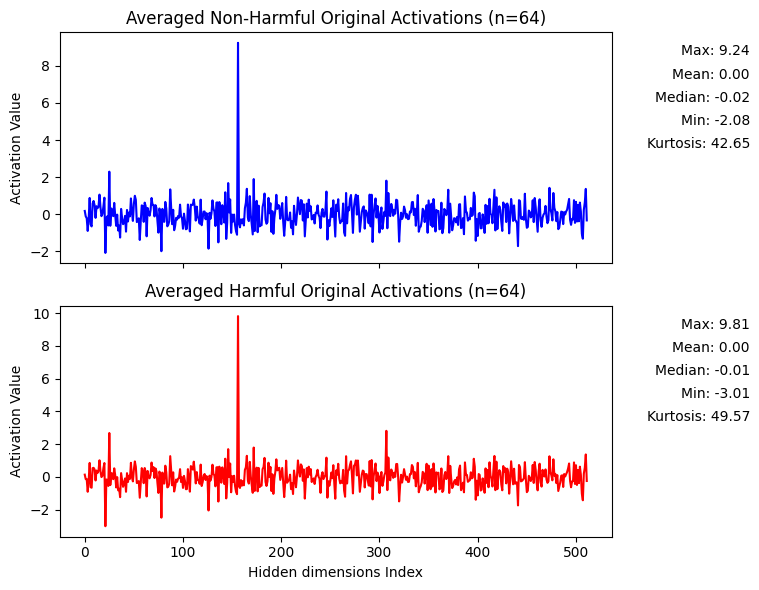

In [142]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import kurtosis

harmful_data = harmful_acts
nonharmful_data = nonharmful_acts

harmful_stats = {
    "max": harmful_data.max(),
    "mean": harmful_data.mean(),
    "median": harmful_data.median(),
    "min": harmful_data.min(), 
    "kurtosis": kurtosis(harmful_data)
}
nonharmful_stats = {
    "max": nonharmful_data.max(),
    "mean": nonharmful_data.mean(),
    "median": nonharmful_data.median(),
    "min": nonharmful_data.min(), 
    "kurtosis": kurtosis(nonharmful_data)
}

# Create two subplots stacked vertically
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# Plot non-harmful data
axes[0].plot(nonharmful_data, label="Non-harmful data", color='blue')
axes[0].set_title("Averaged Non-Harmful Original Activations (n=64)")
# axes[0].legend()
axes[0].set_ylabel("Activation Value")

# Annotate statistics
axes[0].text(1.25, 0.9, f"Max: {nonharmful_stats['max']:.2f}", transform=axes[0].transAxes, fontsize=10, ha='right')
axes[0].text(1.25, 0.8, f"Mean: {nonharmful_stats['mean']:.2f}", transform=axes[0].transAxes, fontsize=10, ha='right')
axes[0].text(1.25, 0.7, f"Median: {nonharmful_stats['median']:.2f}", transform=axes[0].transAxes, fontsize=10, ha='right')
axes[0].text(1.25, 0.6, f"Min: {nonharmful_stats['min']:.2f}", transform=axes[0].transAxes, fontsize=10, ha='right')
axes[0].text(1.25, 0.5, f"Kurtosis: {nonharmful_stats['kurtosis']:.2f}", transform=axes[0].transAxes, fontsize=10, ha='right')

# Plot harmful data
axes[1].plot(harmful_data, label="Harmful data", color='red')
axes[1].set_title("Averaged Harmful Original Activations (n=64)")

axes[1].set_xlabel("Hidden dimensions Index")
axes[1].set_ylabel("Activation Value")
# Annotate statistics
axes[1].text(1.25, 0.9, f"Max: {harmful_stats['max']:.2f}", transform=axes[1].transAxes, fontsize=10, ha='right')
axes[1].text(1.25, 0.8, f"Mean: {harmful_stats['mean']:.2f}", transform=axes[1].transAxes, fontsize=10, ha='right')
axes[1].text(1.25, 0.7, f"Median: {harmful_stats['median']:.2f}", transform=axes[1].transAxes, fontsize=10, ha='right')
axes[1].text(1.25, 0.6, f"Min: {harmful_stats['min']:.2f}", transform=axes[1].transAxes, fontsize=10, ha='right')
axes[1].text(1.25, 0.5, f"Kurtosis: {harmful_stats['kurtosis']:.2f}", transform=axes[1].transAxes, fontsize=10, ha='right')


# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


/var/folders/z2/338wc_l91cb7482t8gghnrxc0000gn/T/ipykernel_77463/369361177.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  annotate_plot(t.tensor(left_plot_data), 1)
/var/folders/z2/338wc_l91cb7482t8gghnrxc0000gn/T/ipykernel_77463/369361177.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  annotate_plot(t.tensor(right_plot_data), 2)


[Text(1, 0, 'Non harmful prompts'), Text(2, 0, 'Harmful prompts')]

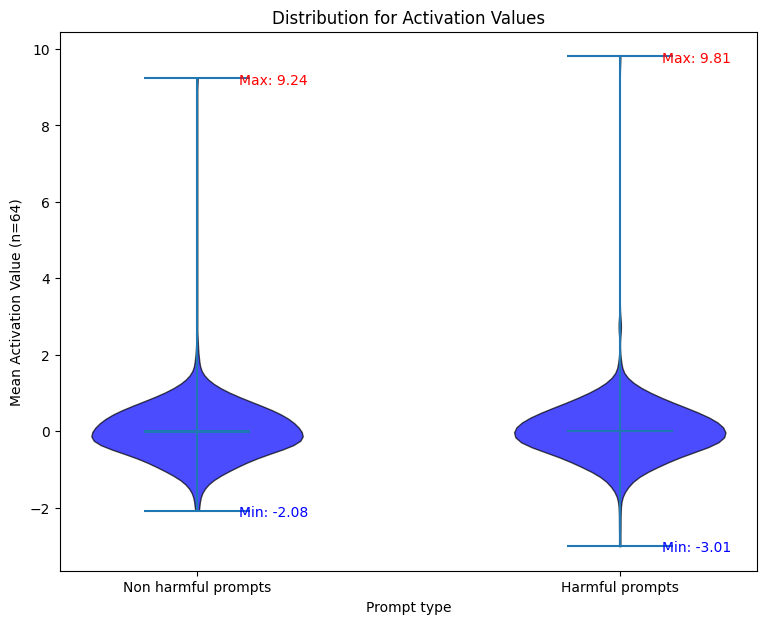

In [140]:

# Example data
# data = [np.random.normal(0, 1, 100), np.random.normal(1, 0.5, 100), np.random.normal(2, 0.7, 100)]
left_plot_data = nonharmful_acts
right_plot_data = harmful_acts

data = [left_plot_data, right_plot_data]
# Create the figure and axes
fig, ax = plt.subplots(figsize=(9, 7))

# Create the violin plot
parts = ax.violinplot(data, showmeans=True, showmedians=True)

# Function to annotate max, min, and median values
def annotate_plot(data, pos):
    # Extract the statistics from the boxplot
    mean = t.mean(data)

    minimum = t.min(data)
    maximum = t.max(data)
    nonzero_counts = len(data)

    plt.text(pos + 0.1, minimum - 0.04, f"Min: {minimum:.2f}", ha='left', va='center', fontsize=10, color='blue')
    # plt.text(pos + 0.1, mean + 0.1, f"Mean: {mean:.2f}", ha='left', va='center', fontsize=10, color='green')
    plt.text(pos + 0.1, maximum - 0.05, f"Max: {maximum:.2f}", ha='left', va='center', fontsize=10, color='red')
    # plt.text(pos - 0.1, maximum - 0.05, f"Non zero counts: {nonzero_counts}", ha='right', va='center', fontsize=10, color='black')

# Annotate both boxplots
annotate_plot(t.tensor(left_plot_data), 1)
annotate_plot(t.tensor(right_plot_data), 2)

# Customize appearance
for pc in parts['bodies']:
    pc.set_facecolor('blue')
    pc.set_edgecolor('black')
    pc.set_alpha(0.7)

ax.set_title("Distribution for Activation Values")
ax.set_xlabel("Prompt type")
ax.set_ylabel("Mean Activation Value (n=64)")
ax.set_xticks([1, 2])  # Set x-tick positions
ax.set_xticklabels([f"Non harmful prompts", f"Harmful prompts"])  # Set


#### sparse activations

In [ ]:
from utils.model_acts_utils import get_sparse_acts

get_sparse_acts(train_harmful)

In [92]:
harmful_fp = "data_latents/train/sparse_acts/harmful_sparse_acts_32768.pt.gz"
nonharmful_fp = "data_latents/train/sparse_acts/nonharmful_sparse_acts_32768.pt.gz"

harmful_sparse_acts = read_from_pt_gz(harmful_fp)
nonharmful_sparse_acts = read_from_pt_gz(nonharmful_fp)

/Users/roselin/Desktop/locating_latent_rep_of_harm/utils/data_utils.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t.load(f)


In [93]:
harmful_sparse_acts.shape, nonharmful_sparse_acts.shape

(torch.Size([64, 26, 32768]), torch.Size([64, 31, 32768]))

In [ ]:
nonharmful_data = nonharmful_sparse_acts[:, -1, :].mean(0) 
harmful_data = harmful_sparse_acts[:, -1, :].mean(0)     

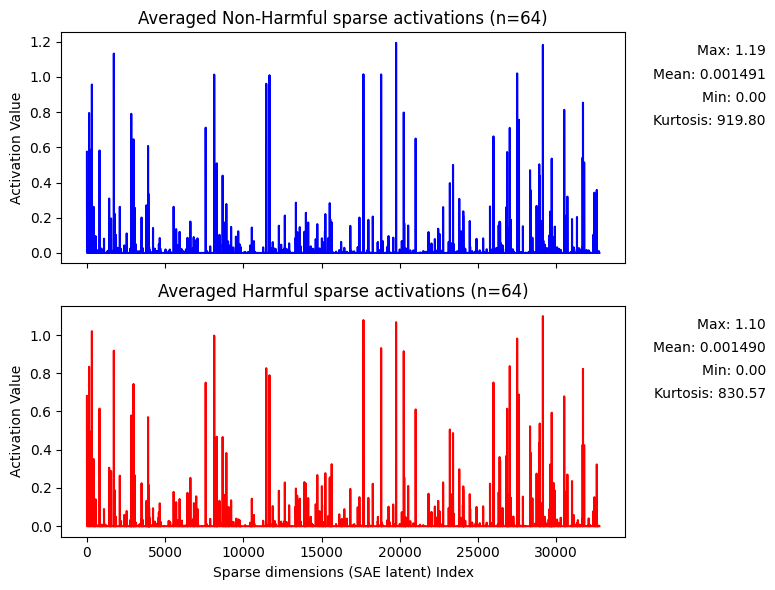

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import kurtosis

harmful_stats = {
    "max": harmful_data.max(),
    "mean": harmful_data.mean(),
    "min": harmful_data.min(), 
    "kurtosis": kurtosis(harmful_data)
}
nonharmful_stats = {
    "max": nonharmful_data.max(),
    "mean": nonharmful_data.mean(),
    "min": nonharmful_data.min(), 
    "kurtosis": kurtosis(nonharmful_data)
}

# Create two subplots stacked vertically
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# Plot non-harmful data
axes[0].plot(nonharmful_data, label="Non-harmful data", color='blue')
axes[0].set_title("Averaged Non-Harmful sparse activations (n=64)")
# axes[0].legend()
axes[0].set_ylabel("Activation Value")

# Annotate statistics
axes[0].text(1.25, 0.9, f"Max: {nonharmful_stats['max']:.2f}", transform=axes[0].transAxes, fontsize=10, ha='right')
axes[0].text(1.25, 0.8, f"Mean: {nonharmful_stats['mean']:.6f}", transform=axes[0].transAxes, fontsize=10, ha='right')
axes[0].text(1.25, 0.7, f"Min: {nonharmful_stats['min']:.2f}", transform=axes[0].transAxes, fontsize=10, ha='right')
axes[0].text(1.25, 0.6, f"Kurtosis: {nonharmful_stats['kurtosis']:.2f}", transform=axes[0].transAxes, fontsize=10, ha='right')

# Plot harmful data
axes[1].plot(harmful_data, label="Harmful data", color='red')
axes[1].set_title("Averaged Harmful sparse activations (n=64)")

axes[1].set_xlabel("Sparse dimensions (SAE latent) Index")
axes[1].set_ylabel("Activation Value")
# Annotate statistics
axes[1].text(1.25, 0.9, f"Max: {harmful_stats['max']:.2f}", transform=axes[1].transAxes, fontsize=10, ha='right')
axes[1].text(1.25, 0.8, f"Mean: {harmful_stats['mean']:.6f}", transform=axes[1].transAxes, fontsize=10, ha='right')
axes[1].text(1.25, 0.7, f"Min: {harmful_stats['min']:.2f}", transform=axes[1].transAxes, fontsize=10, ha='right')
axes[1].text(1.25, 0.6, f"Kurtosis: {harmful_stats['kurtosis']:.2f}", transform=axes[1].transAxes, fontsize=10, ha='right')


# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
## plot only nonzero values 
nonzero_nonharmful = [v for v in nonharmful_data if v != 0]
nonzero_harmful = [v for v in harmful_data if v != 0]


In [88]:
len(nonzero_nonharmful), len(nonzero_harmful)

(544, 512)

Text(0.5, 1.0, 'Comparison of Non-Harmful vs Harmful last token Non-Zero Sparse Activations (full dim=32768)')

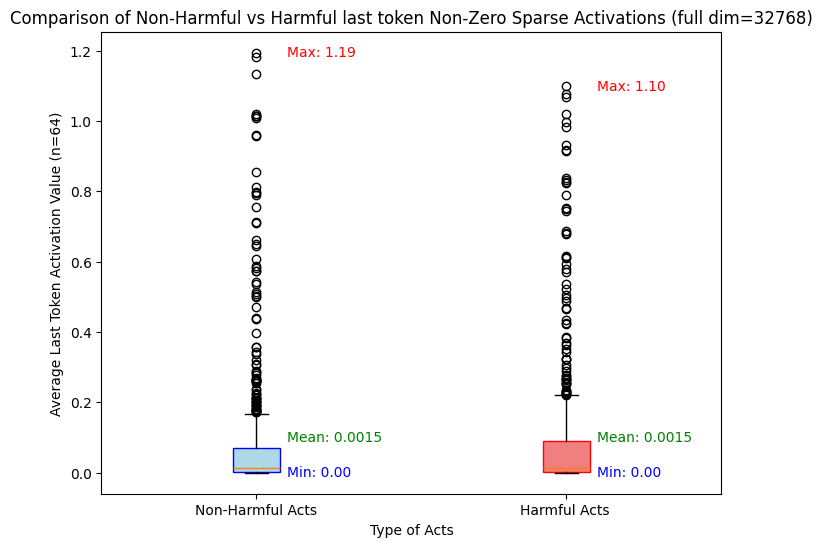

In [98]:
import torch as t

 # Create a figure and axis
plt.figure(figsize=(8, 6))

# Plot nonharmful_acts boxplot at position 1 with a custom color
box_nonharmful = plt.boxplot(nonzero_nonharmful, positions=[1], patch_artist=True, boxprops=dict(facecolor='lightblue', color='blue'))

# Plot harmful_acts boxplot at position 2 with a custom color
box_harmful = plt.boxplot(nonzero_harmful, positions=[2], patch_artist=True, boxprops=dict(facecolor='lightcoral', color='red'))

# Function to annotate max, min, and median values
def annotate_boxplot(data, pos):
    # Extract the statistics from the boxplot
    mean = t.mean(data)
    minimum = t.min(data)
    maximum = t.max(data)

    plt.text(pos + 0.1, minimum, f"Min: {minimum:.2f}", ha='left', va='center', fontsize=10, color='blue')
    plt.text(pos + 0.1, mean + 0.1, f"Mean: {mean:.4f}", ha='left', va='center', fontsize=10, color='green')
    plt.text(pos + 0.1, maximum, f"Max: {maximum:.2f}", ha='left', va='center', fontsize=10, color='red')

# Annotate both boxplots
annotate_boxplot(nonharmful_data, 1)
annotate_boxplot(harmful_data, 2)

# Set the x-axis labels
# plt.xticks([1, 2], [f'Non-Harmful Acts n={len(nonzero_nonharmful)}', f'Harmful Acts n={len(nonzero_harmful)}'])
plt.xticks([1, 2], [f'Non-Harmful Acts', f'Harmful Acts '])

# Optional: Add labels and title
plt.xlabel('Type of Acts')
plt.ylabel('Average Last Token Activation Value (n=64)')
plt.title('Comparison of Non-Harmful vs Harmful last token Non-Zero Sparse Activations (full dim=32768)')


[Text(1, 0, 'Non harmful prompts 544 '), Text(2, 0, 'Harmful prompts 512')]

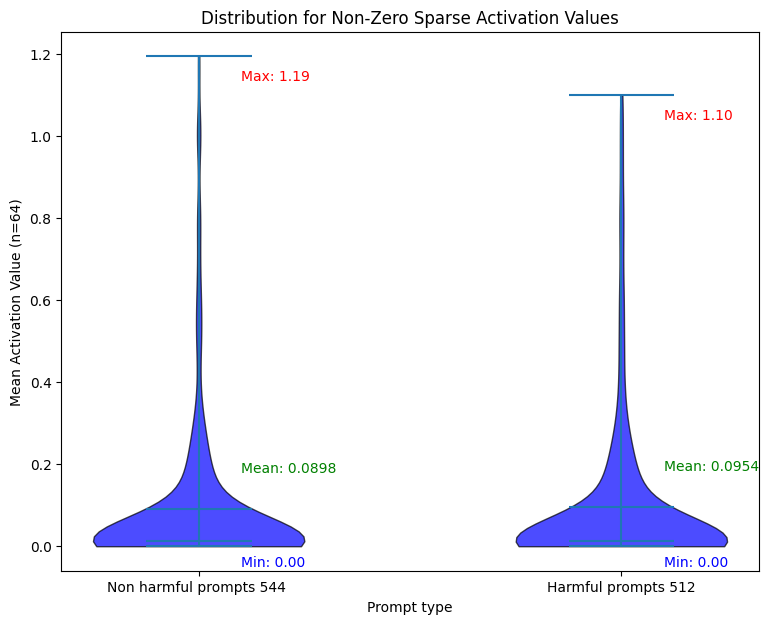

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
# data = [np.random.normal(0, 1, 100), np.random.normal(1, 0.5, 100), np.random.normal(2, 0.7, 100)]
data = [nonzero_nonharmful, nonzero_harmful]
# Create the figure and axes
fig, ax = plt.subplots(figsize=(9, 7))

# Create the violin plot
parts = ax.violinplot(data, showmeans=True, showmedians=True)

# Function to annotate max, min, and median values
def annotate_plot(data, pos):
    # Extract the statistics from the boxplot
    mean = t.mean(data)
    minimum = t.min(data)
    maximum = t.max(data)
    nonzero_counts = len(data)

    plt.text(pos + 0.1, minimum - 0.04, f"Min: {minimum:.2f}", ha='left', va='center', fontsize=10, color='blue')
    plt.text(pos + 0.1, mean + 0.1, f"Mean: {mean:.4f}", ha='left', va='center', fontsize=10, color='green')
    plt.text(pos + 0.1, maximum - 0.05, f"Max: {maximum:.2f}", ha='left', va='center', fontsize=10, color='red')
    # plt.text(pos - 0.1, maximum - 0.05, f"Non zero counts: {nonzero_counts}", ha='right', va='center', fontsize=10, color='black')

# Annotate both boxplots
annotate_plot(t.tensor(nonzero_nonharmful), 1)
annotate_plot(t.tensor(nonzero_harmful), 2)

# Customize appearance
for pc in parts['bodies']:
    pc.set_facecolor('blue')
    pc.set_edgecolor('black')
    pc.set_alpha(0.7)

ax.set_title("Distribution for Non-Zero Sparse Activation Values")
ax.set_xlabel("Prompt type")
ax.set_ylabel("Mean Activation Value (n=64)")
ax.set_xticks([1, 2])  # Set x-tick positions
ax.set_xticklabels([f"Non harmful prompts (n={len(nonzero_nonharmful)})", f"Harmful prompts {len(nonzero_harmful)}"])  # Set


## test data: original and perturbed
- seems to not have significant differences

In [9]:
from utils.data_utils import read_from_pt_gz
import matplotlib.pyplot as plt
from scipy.stats import kurtosis


In [5]:
harmful_fp = "data_latents/test/acts/harmful_acts_512.pt.gz"
nonharmful_fp = "data_latents/test/acts/nonharmful_acts_512.pt.gz"
harmful_perturbed_fp = "data_latents/test_perturbed/acts/harmful_acts_512.pt.gz"

harmful_acts = read_from_pt_gz(harmful_fp)
nonharmful_acts = read_from_pt_gz(nonharmful_fp)
harmful_acts_test_perturbed = read_from_pt_gz(harmful_perturbed_fp)


/Users/roselin/Desktop/locating_latent_rep_of_harm/utils/data_utils.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t.load(f)


#### perturbed activations (harmful perturbed)

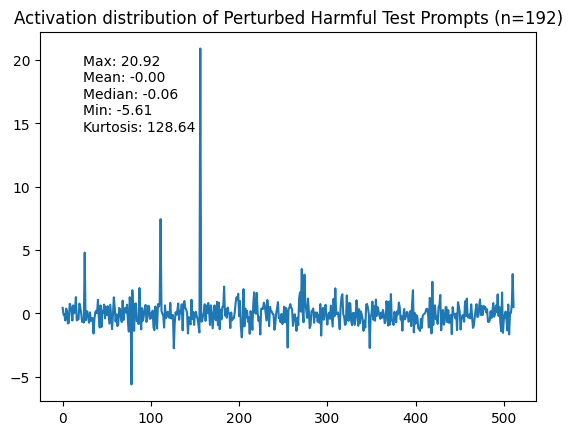

In [13]:
plt.title('Activation distribution of Perturbed Harmful Test Prompts (n=192)')
harmful_data = harmful_acts_test_perturbed[:, -1, :].mean(0)
stats = {
        "max": harmful_data.max(),
        "mean": harmful_data.mean(),
        "median": harmful_data.median(),
        "min": harmful_data.min(), 
        "kurtosis": kurtosis(harmful_data)
    }
# Annotate statistics
plt.text(stats['max'] + 2, stats['max'] - harmful_data.std(), f"Max: {stats['max']:.2f}", fontsize=10, ha='left')
plt.text(stats['max'] + 2, stats['max'] - harmful_data.std()*2, f"Mean: {stats['mean']:.2f}", fontsize=10, ha='left')
plt.text(stats['max'] + 2, stats['max'] - harmful_data.std()*3, f"Median: {stats['median']:.2f}", fontsize=10, ha='left')
plt.text(stats['max'] + 2, stats['max'] - harmful_data.std()*4, f"Min: {stats['min']:.2f}", fontsize=10, ha='left')
plt.text(stats['max'] + 2, stats['max'] - harmful_data.std()*5, f"Kurtosis: {stats['kurtosis']:.2f}", fontsize=10, ha='left')

plt.plot(harmful_acts_test_perturbed[:, -1, :].mean(0).detach().numpy())

#### test activations (harmful only)

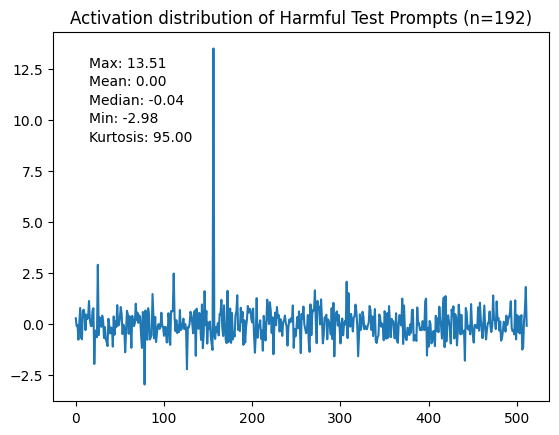

In [15]:
plt.title('Activation distribution of Harmful Test Prompts (n=192)')
harmful_data = harmful_acts[:, -1, :].mean(0)
stats = {
        "max": harmful_data.max(),
        "mean": harmful_data.mean(),
        "median": harmful_data.median(),
        "min": harmful_data.min(), 
        "kurtosis": kurtosis(harmful_data)
    }
# Annotate statistics
plt.text(stats['max'] + 2, stats['max'] - harmful_data.std(), f"Max: {stats['max']:.2f}", fontsize=10, ha='left')
plt.text(stats['max'] + 2, stats['max'] - harmful_data.std()*2, f"Mean: {stats['mean']:.2f}", fontsize=10, ha='left')
plt.text(stats['max'] + 2, stats['max'] - harmful_data.std()*3, f"Median: {stats['median']:.2f}", fontsize=10, ha='left')
plt.text(stats['max'] + 2, stats['max'] - harmful_data.std()*4, f"Min: {stats['min']:.2f}", fontsize=10, ha='left')
plt.text(stats['max'] + 2, stats['max'] - harmful_data.std()*5, f"Kurtosis: {stats['kurtosis']:.2f}", fontsize=10, ha='left')

plt.plot(harmful_acts[:, -1, :].mean(0).detach().numpy())

In [19]:
harmful_acts.shape

torch.Size([192, 31, 512])

#### test activations (nonharmful and harmful)

In [16]:
harmful_data = harmful_acts[:, -1, :].mean(0)
nonharmful_data = nonharmful_acts[:, -1, :].mean(0)

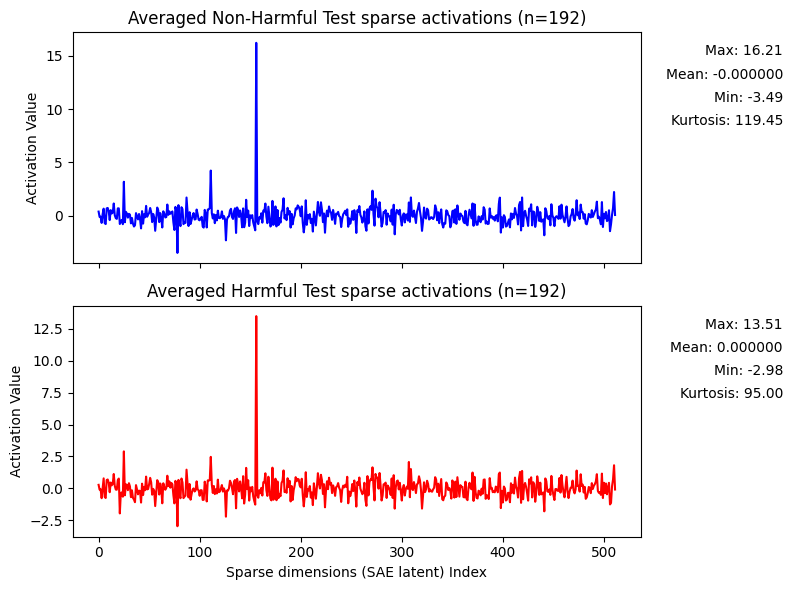

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import kurtosis

harmful_stats = {
    "max": harmful_data.max(),
    "mean": harmful_data.mean(),
    "min": harmful_data.min(), 
    "kurtosis": kurtosis(harmful_data)
}
nonharmful_stats = {
    "max": nonharmful_data.max(),
    "mean": nonharmful_data.mean(),
    "min": nonharmful_data.min(), 
    "kurtosis": kurtosis(nonharmful_data)
}

# Create two subplots stacked vertically
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# Plot non-harmful data
axes[0].plot(nonharmful_data, label="Non-harmful data", color='blue')
axes[0].set_title("Averaged Non-Harmful Test sparse activations (n=192)")
# axes[0].legend()
axes[0].set_ylabel("Activation Value")

# Annotate statistics
axes[0].text(1.25, 0.9, f"Max: {nonharmful_stats['max']:.2f}", transform=axes[0].transAxes, fontsize=10, ha='right')
axes[0].text(1.25, 0.8, f"Mean: {nonharmful_stats['mean']:.6f}", transform=axes[0].transAxes, fontsize=10, ha='right')
axes[0].text(1.25, 0.7, f"Min: {nonharmful_stats['min']:.2f}", transform=axes[0].transAxes, fontsize=10, ha='right')
axes[0].text(1.25, 0.6, f"Kurtosis: {nonharmful_stats['kurtosis']:.2f}", transform=axes[0].transAxes, fontsize=10, ha='right')

# Plot harmful data
axes[1].plot(harmful_data, label="Harmful data", color='red')
axes[1].set_title("Averaged Harmful Test sparse activations (n=192)")

axes[1].set_xlabel("Sparse dimensions (SAE latent) Index")
axes[1].set_ylabel("Activation Value")
# Annotate statistics
axes[1].text(1.25, 0.9, f"Max: {harmful_stats['max']:.2f}", transform=axes[1].transAxes, fontsize=10, ha='right')
axes[1].text(1.25, 0.8, f"Mean: {harmful_stats['mean']:.6f}", transform=axes[1].transAxes, fontsize=10, ha='right')
axes[1].text(1.25, 0.7, f"Min: {harmful_stats['min']:.2f}", transform=axes[1].transAxes, fontsize=10, ha='right')
axes[1].text(1.25, 0.6, f"Kurtosis: {harmful_stats['kurtosis']:.2f}", transform=axes[1].transAxes, fontsize=10, ha='right')


# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()
